In [44]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal



class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        mean_pi_losses = []
        mean_v_losses = []

        for epoch in range(self.epoch_n):
            pi_losses = []
            v_losses = []
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns.detach() - self.v_model(b_states)
                b_advantage_normalized = (b_advantage - torch.mean(b_advantage)) / torch.std(b_advantage)
                
                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage_normalized.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage_normalized.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))

                pi_losses.append(pi_loss.data.numpy())
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)

                v_losses.append(v_loss.data.numpy())
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()
            mean_pi_losses.append(np.mean(pi_losses))
            mean_v_losses.append(np.mean(v_losses))
        return mean_pi_losses, mean_v_losses

In [63]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal

torch.manual_seed(42)

class PPO_one_step(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())

        for name, parameter in self.pi_model.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(parameter.data)

        self.pi_layers_list = [self.pi_model[0], self.pi_model[2], self.pi_model[4]]
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))

        for name, parameter in self.v_model.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(parameter.data)

        self.v_layers_list = [self.v_model[0], self.v_model[2], self.v_model[4]]
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, next_states, dones):
        
        states, actions, rewards, next_states, dones = map(np.array, [states, actions, rewards, next_states, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)
        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, rewards, next_states, returns = map(torch.FloatTensor, [states, actions, rewards, next_states,returns])


        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()


        mean_pi_losses = []
        mean_v_losses = []
        mean_pi_grads = []
        mean_v_grads = []

        for epoch in range(self.epoch_n):
            pi_losses = []
            v_losses = []
            pi_grads = []
            v_grads = []
            idxs = np.random.permutation(rewards.shape[0])
            for i in range(0, rewards.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_rewards = rewards[b_idxs]
                b_returns = returns[b_idxs]
                b_next_states = next_states[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_rewards.detach() + self.v_model(b_next_states).detach() - self.v_model(b_states)
                
                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)

                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))

                pi_losses.append(pi_loss.data.numpy())
                
                pi_loss.backward()

                pi_norms = 0
                for layer in self.pi_layers_list:
                    pi_norms += layer.weight.grad.norm()
                pi_grads.append(pi_norms)
                
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean((b_returns.detach() - self.v_model(b_states)) ** 2)

                v_losses.append(v_loss.data.numpy())
    
                v_loss.backward()

                v_norms = 0
                for layer in self.v_layers_list:
                    v_norms += layer.weight.grad.norm()
                v_grads.append(v_norms)

                nn.utils.clip_grad_norm_(self.v_model.parameters(), max_norm=0.1)
                
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()
            mean_pi_losses.append(np.mean(pi_losses))
            mean_v_losses.append(np.mean(v_losses))
            mean_pi_grads.append(np.mean(pi_grads))
            mean_v_grads.append(np.mean(v_grads))
        return mean_pi_losses, mean_v_losses, mean_pi_grads, mean_v_grads
        

/home/arttol/old_gym_enviroment/lib/python3.10/site-packages/gym/utils/env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


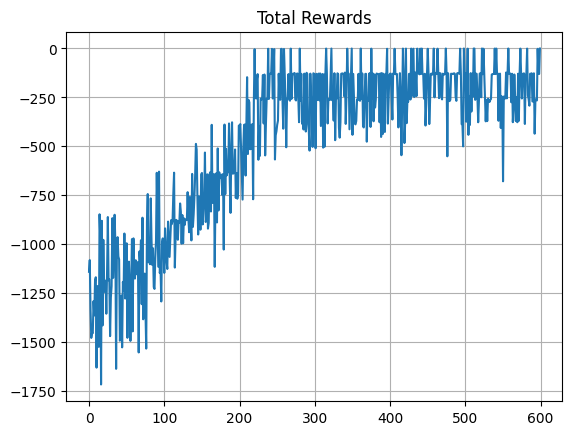

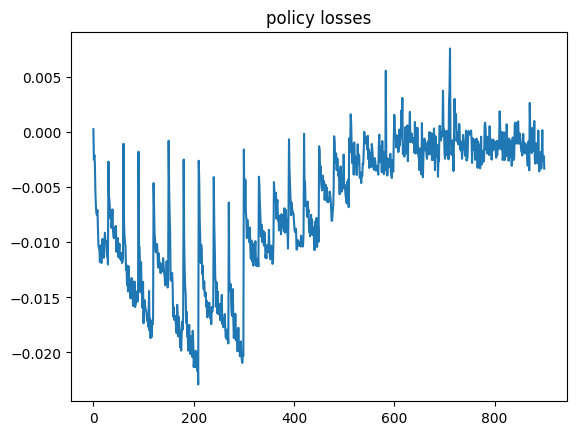

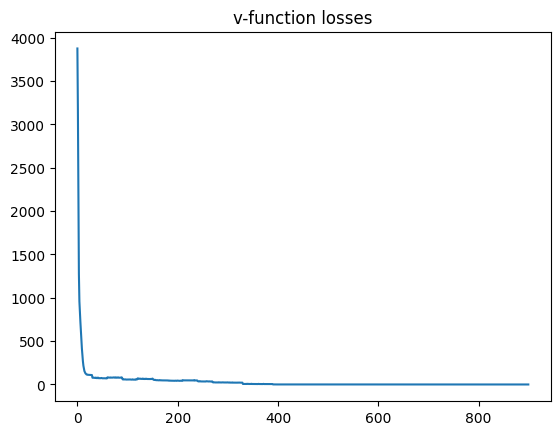

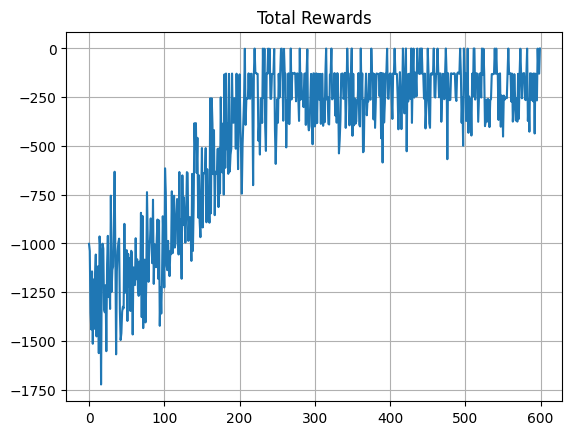

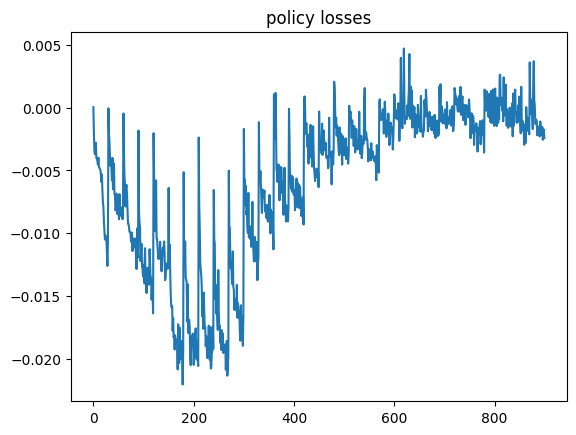

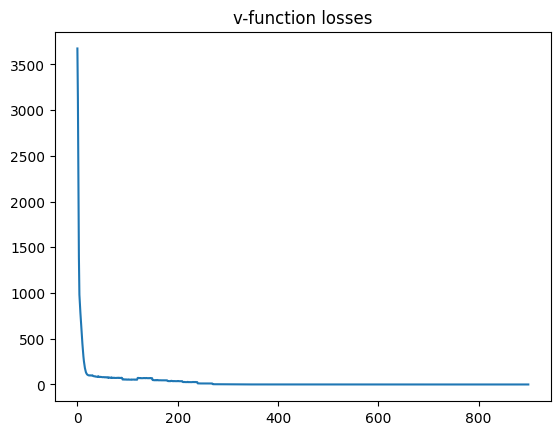

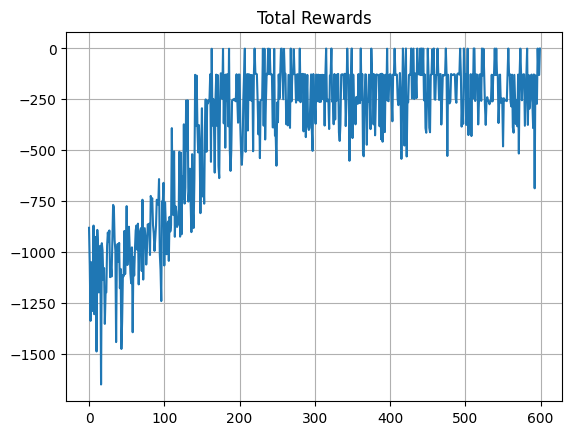

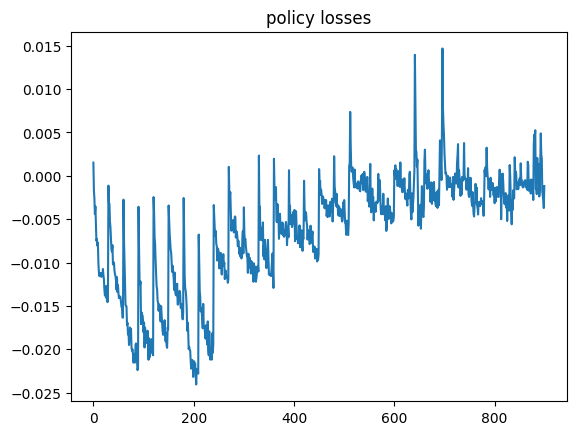

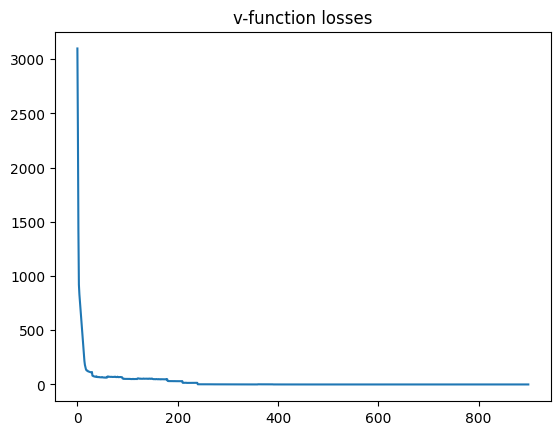

In [285]:
totals = []
for i in range(3):
    env = gym.make('Pendulum-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    agent = PPO(state_dim, action_dim)
    
    episode_n = 30
    trajectory_n = 20
    
    total_rewards = []
    
    mean_pi_losses = []
    mean_v_losses = []
    
    for episode in range(episode_n):
    
        states, actions, rewards, dones = [], [], [], []
    
        for _ in range(trajectory_n):
            total_reward = 0
    
            state = env.reset()
            for t in range(200):
                states.append(state)
                
                action = agent.get_action(state)
                actions.append(action)
                
                state, reward, done, _ = env.step(2 * action)
                rewards.append(reward)
                dones.append(done)
    
                total_reward += reward
    
            total_rewards.append(total_reward)
    
        _mean_pi_losses, _mean_v_losses = agent.fit(states, actions, rewards, dones)
        mean_pi_losses.extend(_mean_pi_losses)
        mean_v_losses.extend(_mean_v_losses)
    totals.append(total_rewards)
    plt.plot(total_rewards)
    plt.title('Total Rewards')
    plt.grid()
    plt.show()
    plt.plot(mean_pi_losses)
    plt.title('policy losses')
    plt.show()
    plt.plot(mean_v_losses)
    plt.title('v-function losses')
    plt.show()
with open('PPO_Pendulum 3tr.json', 'w') as f:
    json.dump(totals, f)

In [3]:
def save_checkpoint(model, checkpoint_path='./checkpoint_simple_model.pth'):
    state = {'model_dict': model.state_dict()}
    torch.save(state, checkpoint_path)

def load_checkpoint(model, checkpoint_path='./checkpoint_simple_model.pth'):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['model_dict'])
    print('model loaded from %s' % checkpoint_path)

In [4]:
save_checkpoint(agent.pi_model, checkpoint_path='./ppo_pi_model.ptx')
save_checkpoint(agent.v_model, checkpoint_path='./ppo_v_model.ptx')

In [7]:
x = torch.tensor([1, 2, 3, 4])
x.shape

torch.Size([4])

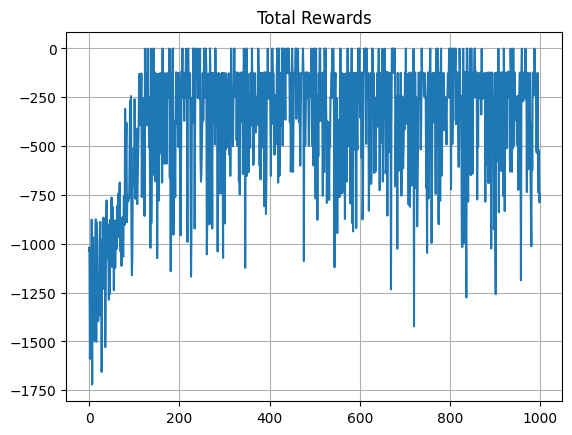

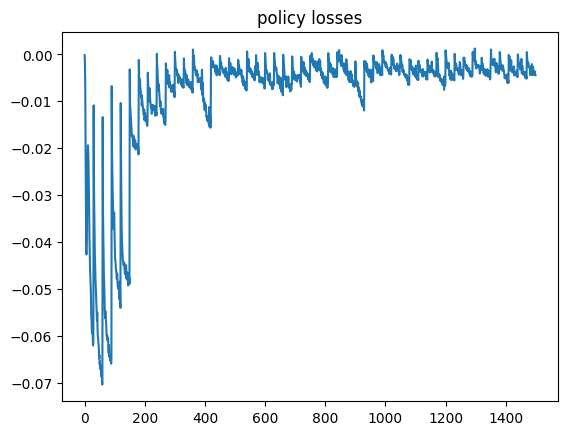

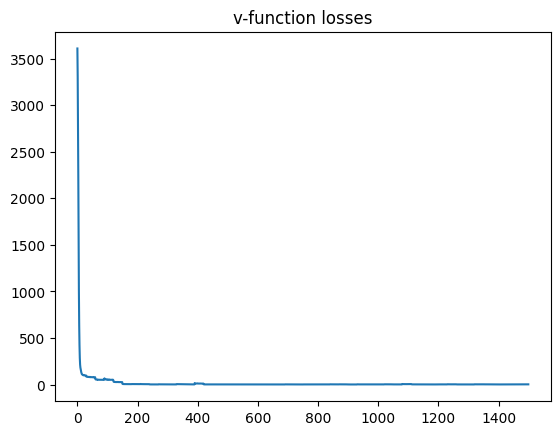

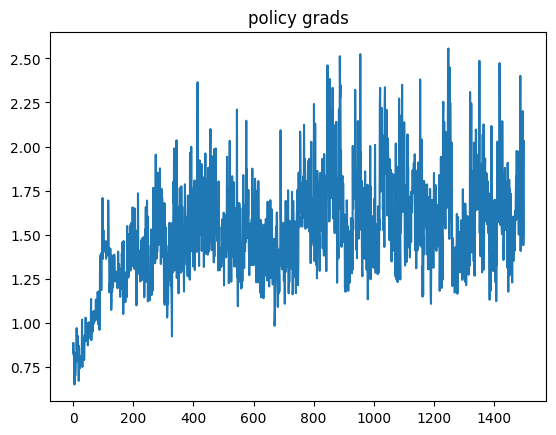

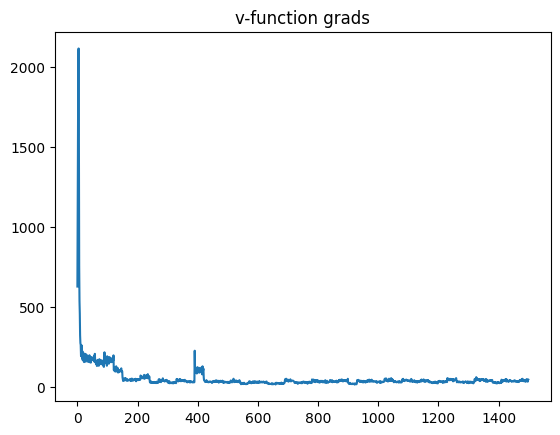

In [62]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO_one_step(state_dim, action_dim)

episode_n = 50
trajectory_n = 20

total_rewards = []

mean_pi_losses = []
mean_v_losses = []
mean_pi_grads = []
mean_v_grads = []

for episode in range(episode_n):

    states, actions, rewards, next_states, dones = [], [], [], [], []

    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(200):
            states.append(state)
            
            action = agent.get_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(2 * action)
            rewards.append(reward)
            next_states.append(state)
            dones.append(done)

            total_reward += reward

        total_rewards.append(total_reward)

    _mean_pi_losses, _mean_v_losses, _mean_pi_grads, _mean_v_grads = agent.fit(states, actions, rewards, next_states, dones)
    mean_pi_losses.extend(_mean_pi_losses)
    mean_v_losses.extend(_mean_v_losses)
    mean_pi_grads.extend(_mean_pi_grads)
    mean_v_grads.extend(_mean_v_grads)

plt.plot(total_rewards)
plt.title('Total Rewards')
plt.grid()
plt.show()
plt.plot(mean_pi_losses)
plt.title('policy losses')
plt.show()
plt.plot(mean_v_losses)
plt.title('v-function losses')
plt.show()
plt.plot(mean_pi_grads)
plt.title('policy grads')
plt.show()
plt.plot(mean_v_grads)
plt.title('v-function grads')
plt.show()

In [155]:
import json

with open('ppo_many_dims_1.json', 'w') as f:
    json.dump(total_rewards, f)

#### Случай с многомерным пространством действий

In [280]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal
from torch.linalg import matrix_norm

torch.manual_seed(43)

class PPO_many_dims(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):
        super().__init__()
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())

        for name, parameter in self.pi_model.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(parameter.data)

        self.pi_layers_list = [self.pi_model[0], self.pi_model[2], self.pi_model[4]]
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))

        for name, parameter in self.v_model.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(parameter.data)

        self.v_layers_list = [self.v_model[0], self.v_model[2], self.v_model[4]]

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)
        # lmbd = lambda epoch: 0.97**epoch
        # self.pi_scheduler = torch.optim.lr_scheduler.LambdaLR(self.pi_optimizer, lr_lambda=lmbd)
        # self.v_scheduler = torch.optim.lr_scheduler.LambdaLR(self.v_optimizer, lr_lambda=lmbd)

    def get_action(self, state):
        raw_action = self.pi_model(torch.FloatTensor(state))
        raw_action = raw_action.reshape(self.action_dim, 2)
        mean = raw_action[:, 0].unsqueeze(1)
        log_std = raw_action[:, 1].unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        action = torch.clamp(action, -1, 1)
        
        return action.numpy().reshape(-1)

    def fit(self, states, actions, rewards, dones):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])

        mean1, log_std1, mean2, log_std2 = self.pi_model(states).T
        mean1, log_std1, mean2, log_std2 = mean1.unsqueeze(1), log_std1.unsqueeze(1), mean2.unsqueeze(1) , log_std2.unsqueeze(1)
        mean = torch.cat((mean1, mean2), 1)
        log_std = torch.cat((log_std1, log_std2), 1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        mean_pi_losses = []
        mean_v_losses = []
        mean_pi_grads = []
        mean_v_grads = []
        mean_pi_std = []

        for epoch in range(self.epoch_n):

            pi_losses = []
            v_losses = []
            pi_grads = []
            v_grads = []
            pi_std = []
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns.detach() - self.v_model(b_states)

                b_mean1, b_log_std1, b_mean2, b_log_std2 = self.pi_model(b_states).T
                b_mean1, b_log_std1, b_mean2, b_log_std2 = b_mean1.unsqueeze(1), b_log_std1.unsqueeze(1), b_mean2.unsqueeze(1) , b_log_std2.unsqueeze(1)
                b_mean = torch.cat((b_mean1, b_mean2), 1)
                b_log_std = torch.cat((b_log_std1, b_log_std2), 1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)

                pi_std.append(matrix_norm(torch.exp(b_log_std.detach())) / np.sqrt(2 * self.batch_size))
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))

                pi_losses.append(pi_loss.data.numpy())
                
                pi_loss.backward()

                pi_norms = 0
                for layer in self.pi_layers_list:
                    pi_norms += layer.weight.grad.norm() / np.sqrt(layer.weight.shape[0] * layer.weight.shape[1])
                pi_grads.append(pi_norms / len(self.pi_layers_list))

                nn.utils.clip_grad_norm_(self.pi_model.parameters(), max_norm=0.1)
                
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)

                v_losses.append(v_loss.data.numpy())
    
                v_loss.backward()

                v_norms = 0
                for layer in self.v_layers_list:
                    v_norms += layer.weight.grad.norm() / np.sqrt(layer.weight.shape[0] * layer.weight.shape[1])
                v_grads.append(pi_norms / len(self.v_layers_list))

                nn.utils.clip_grad_norm_(self.v_model.parameters(), max_norm=0.1)
                
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()
            # шаг шедулера    
            # self.pi_scheduler.step()
            # self.v_scheduler.step()
            
            mean_pi_losses.append(np.mean(pi_losses))
            mean_v_losses.append(np.mean(v_losses))
            mean_pi_grads.append(np.mean(pi_grads))
            mean_v_grads.append(np.mean(v_grads))
            mean_pi_std.append(np.mean(pi_std))
        return mean_pi_losses, mean_v_losses, mean_pi_grads, mean_v_grads, mean_pi_std

In [281]:
def ppo_tests(batch_size=128, epoch_n=30, epsilon=0.2, _trajectory_n=20):
    env = gym.make('LunarLander-v2', continuous=True)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    agent = PPO_many_dims(state_dim, action_dim, epoch_n=epoch_n, batch_size=batch_size, epsilon=epsilon)
    
    episode_n = 60
    trajectory_n = _trajectory_n
    
    total_rewards = []
    
    mean_pi_losses = []
    mean_v_losses = []
    mean_pi_grads = []
    mean_v_grads = []
    mean_pi_std = []
    
    for episode in range(episode_n):
    
        states, actions, rewards,  dones = [], [], [], []
    
        for _ in range(trajectory_n):
            total_reward = 0
    
            state = env.reset()
            for t in range(700):
                states.append(state)
                
                action = agent.get_action(state)
                actions.append(action)
                
                state, reward, done, _ = env.step(action)
                rewards.append(reward)
                dones.append(done)
    
                total_reward += reward
                if done:
                    break
    
            total_rewards.append(total_reward)
    
        _mean_pi_losses, _mean_v_losses, _mean_pi_grads, _mean_v_grads, _mean_pi_std = agent.fit(states, actions, rewards, dones)
        mean_pi_losses.extend(_mean_pi_losses)
        mean_v_losses.extend(_mean_v_losses)
        mean_pi_grads.extend(_mean_pi_grads)
        mean_v_grads.extend(_mean_v_grads)
        mean_pi_std.extend(_mean_pi_std)
    
    plt.plot(total_rewards)
    plt.title(f'Total Rewards batch_size={batch_size}_epoch_n={epoch_n}_epsilon={epsilon}')
    plt.grid()
    plt.show()
    plt.plot(mean_pi_losses)
    plt.title(f'Mean pi losses batch_size={batch_size}_epoch_n={epoch_n}_epsilon={epsilon}')
    plt.show()
    plt.plot(mean_v_losses)
    plt.title(f'v-function losses batch_size={batch_size}_epoch_n={epoch_n}_epsilon={epsilon}')
    plt.show()
    plt.plot(mean_pi_grads)
    plt.title(f'policy grads batch_size={batch_size}_epoch_n={epoch_n}_epsilon={epsilon}')
    plt.show()
    plt.plot(mean_v_grads)
    plt.title(f'v-function grads batch_size={batch_size}_epoch_n={epoch_n}_epsilon={epsilon}')
    plt.show()
    plt.plot(mean_pi_std)
    plt.title(f'policy stds batch_size={batch_size}_epoch_n={epoch_n}_epsilon={epsilon}')
    plt.show()
    with open(f'ppo_many_dims_batch_size={batch_size}_epoch_n={epoch_n}_epsilon={epsilon}_trajectory_n={trajectory_n}_SOLVED_2.json', 'w') as f:
        json.dump(total_rewards, f)
    

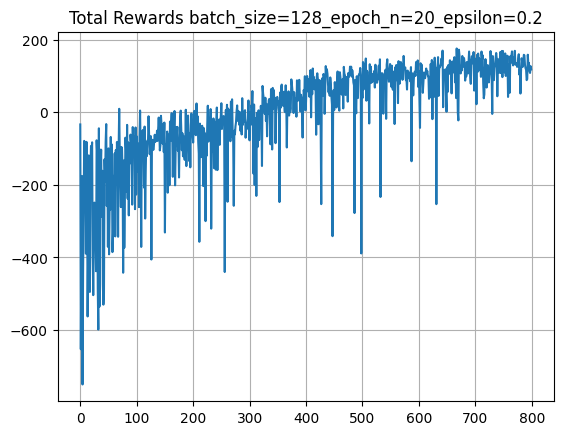

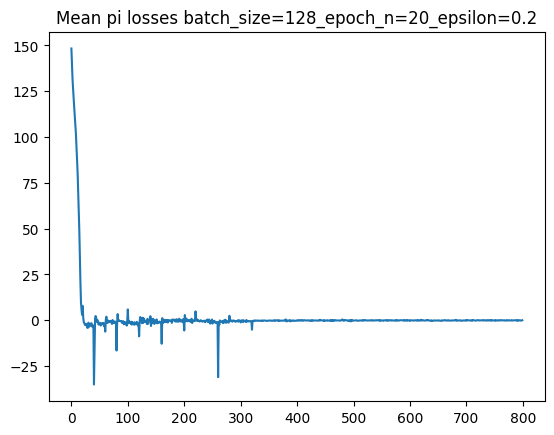

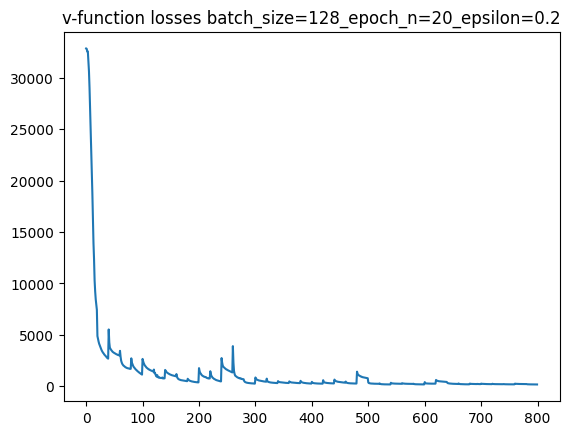

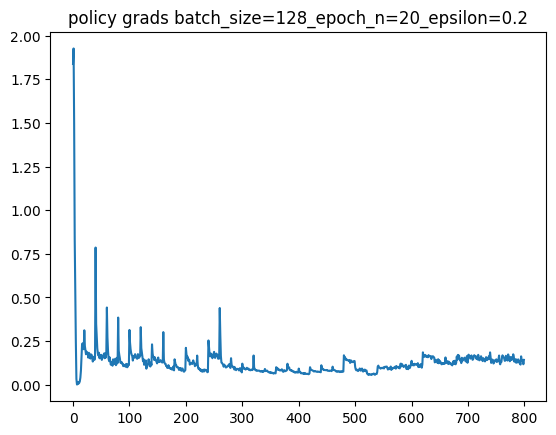

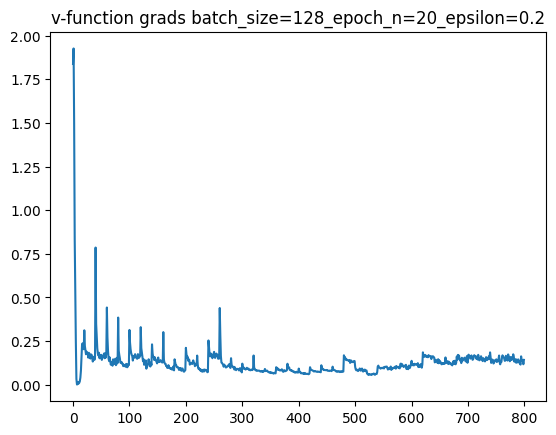

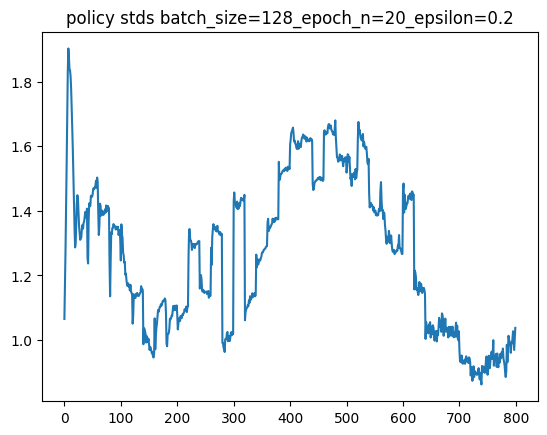

In [283]:
batch_sizes=[128]
epochs_n=[20]
epsilons=[0.2]
trajectorys_n = [20]

for batch_size in batch_sizes:
    for epoch_n in epochs_n:
        for epsilon in epsilons:
            for trajectory_n in trajectorys_n:
                ppo_tests(batch_size, epoch_n, epsilon, trajectory_n)

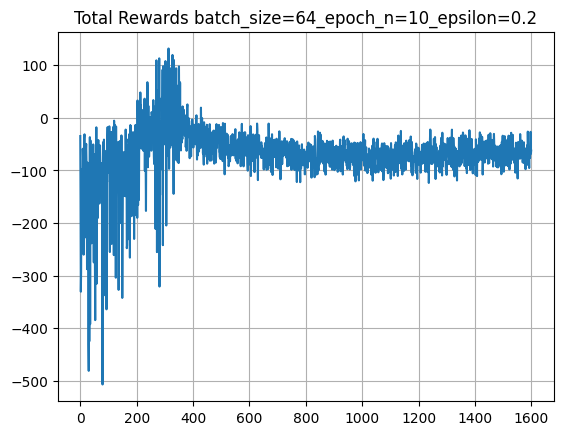

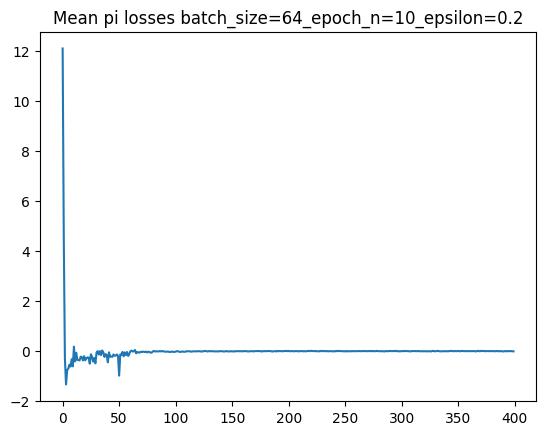

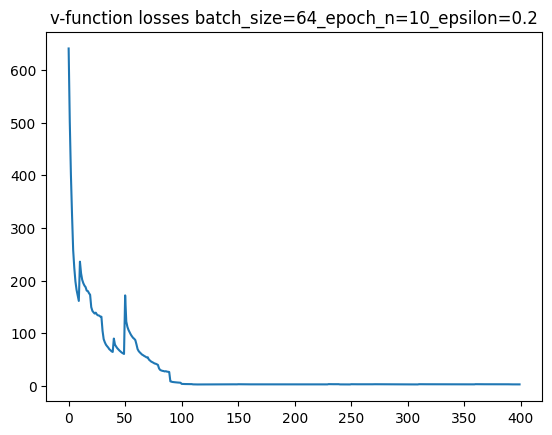

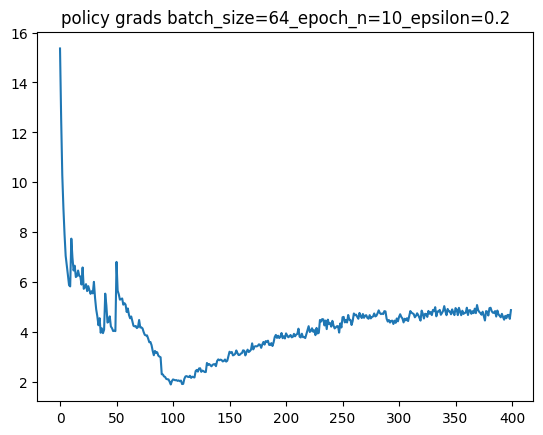

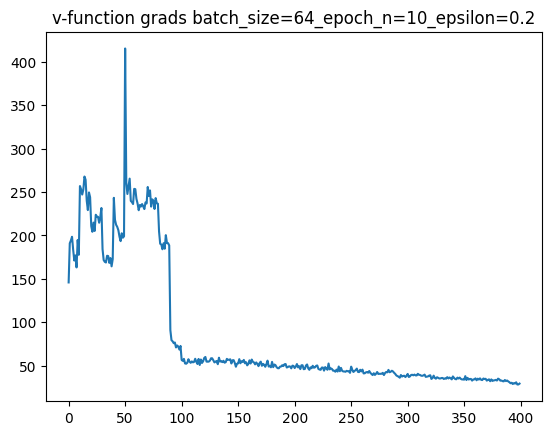

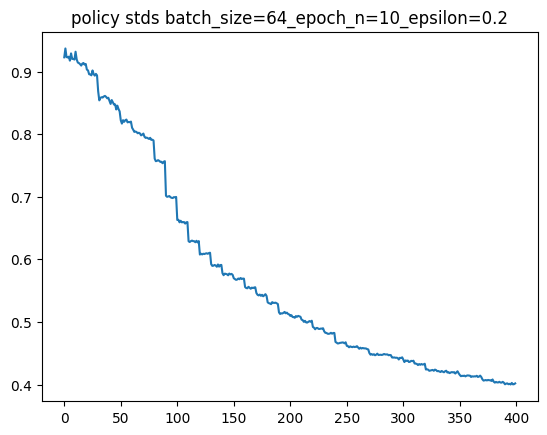

KeyboardInterrupt: 

In [257]:
batch_sizes=[64, 128]
epochs_n=[10, 30]
epsilons=[0.2]
trajectorys_n = [20]

for batch_size in batch_sizes:
    for epoch_n in epochs_n:
        for epsilon in epsilons:
            for trajectory_n in trajectorys_n:
                ppo_tests(batch_size, epoch_n, epsilon, trajectory_n)

In [88]:
x = torch.tensor([1, 2, 3, 4, 5, 6])
x.numpy().reshape(3, 2)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [121]:
x = torch.tensor([[1, 1], [1, 1], [1, 1]], dtype=torch.float)
dist = Normal(x, x)
dist.log_prob(torch.tensor([[1, 2], [1, 2], [1, 2]]))

tensor([[-0.9189, -1.6121],
        [-2.2398, -2.4302],
        [-2.8484, -2.9329]])

##### проверить как ведут себя стандартные отклонения. Такое ощущение, что выучивается детерминированная политика.

#### делаем конечномерное пространство ответов

In [193]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal
from torch.distributions.categorical import Categorical

torch.manual_seed(42)

class PPO_finite_dim(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, action_dim), nn.Softmax())
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        probs = self.pi_model(torch.FloatTensor(state))
        dist = Categorical(probs=probs)
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])

        probs = self.pi_model(states)
        dist = Categorical(probs=probs)
        old_log_probs = dist.log_prob(actions).detach()

        mean_pi_losses = []
        mean_v_losses = []

        for epoch in range(self.epoch_n):
            pi_losses = []
            v_losses = []
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns.detach() - self.v_model(b_states)
                b_advantage_normalized = (b_advantage - torch.mean(b_advantage)) / torch.std(b_advantage)
                
                b_probs = self.pi_model(b_states)
                b_dist = Categorical(probs=b_probs)
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage_normalized.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage_normalized.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))

                pi_losses.append(pi_loss.data.numpy())
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)

                v_losses.append(v_loss.data.numpy())
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()
            mean_pi_losses.append(np.mean(pi_losses))
            mean_v_losses.append(np.mean(v_losses))
        return mean_pi_losses, mean_v_losses

In [230]:
x = torch.tensor([[1, 1, 1], [1, 1, 1]], dtype=torch.float)
from torch.linalg import matrix_norm
matrix_norm(x) / np.sqrt(3*2)

tensor(1.)

In [240]:
dist = Categorical(probs=torch.tensor([0.25, 0.25, 0.5]))
dist.sample().numpy() ==1
torch.exp(dist.log_prob(torch.tensor([1, 2, 0])))

tensor([0.2500, 0.5000, 0.2500])